# Assignment 4
## Econ 8310 - Business Forecasting

This assignment will make use of the bayesian statistical models covered in Lessons 10 to 12.

A/B Testing is a critical concept in data science, and for many companies one of the most relevant applications of data-driven decision-making. In order to improve product offerings, marketing campaigns, user interfaces, and many other user-facing interactions, scientists and engineers create experiments to determine the efficacy of proposed changes. Users are then randomly assigned to either the treatment or control group, and their behavior is recorded.
If the changes that the treatment group is exposed to can be measured to have a benefit in the metric of interest, then those changes are scaled up and rolled out to across all interactions.
Below is a short video detailing the A/B Testing process, in case you want to learn a bit more:
[https://youtu.be/DUNk4GPZ9bw](https://youtu.be/DUNk4GPZ9bw)

For this assignment, you will use an A/B test data set, which was pulled from the Kaggle website (https://www.kaggle.com/datasets/yufengsui/mobile-games-ab-testing). I have added the data from the page into Codio for you. It can be found in the cookie_cats.csv file in the file tree. It can also be found at [https://github.com/dustywhite7/Econ8310/raw/master/AssignmentData/cookie_cats.csv](https://github.com/dustywhite7/Econ8310/raw/master/AssignmentData/cookie_cats.csv)

The variables are defined as follows:

| Variable Name  | Definition |
|----------------|----|
| userid         | A unique number that identifies each player  |
| version        | Whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40) |
| sum_gamerounds | The number of game rounds played by the player during the first 14 days after install.  |
| retention1     | Did the player come back and play 1 day after installing?     |
| retention7     | Did the player come back and play 7 days after installing?    |               

### The questions

You will be asked to answer the following questions in a small quiz on Canvas:
1. What was the effect of moving the gate from level 30 to level 40 on 1-day retention rates?
2. What was the effect of moving the gate from level 30 to level 40 on 7-day retention rates?
3. What was the biggest challenge for you in completing this assignment?

You will also be asked to submit a URL to your forked GitHub repository containing your code used to answer these questions.

Dataset Overview:
--------------------------------------------------
Total Samples: 90189
Versions Distribution:
version
gate_40    45489
gate_30    44700
Name: count, dtype: int64

Retention Rates:
         retention_1  retention_7
version                          
gate_30     0.448188     0.190201
gate_40     0.442283     0.182000


Output()

Output()

Output()

Output()

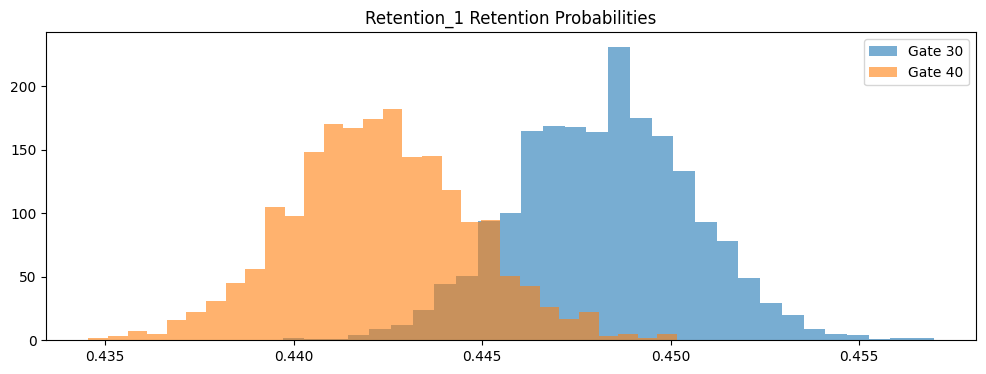

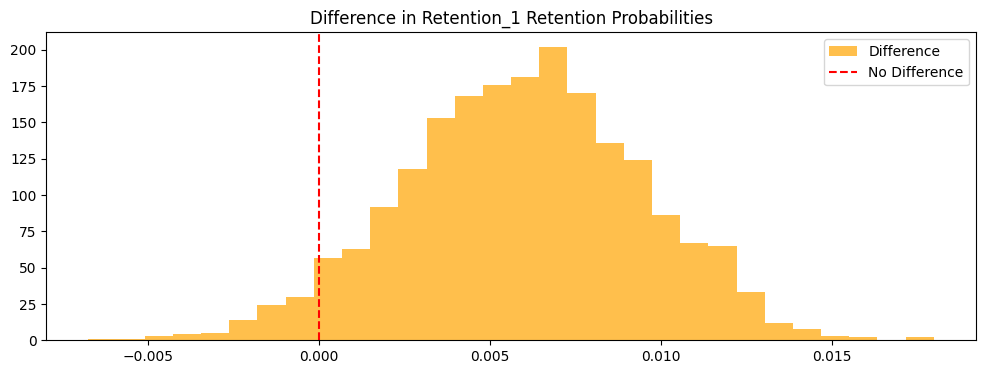


Retention_1 Retention Analysis Summary:
                         mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
p_30_retention_1        0.448  0.002     0.444      0.453        0.0      0.0   
p_40_retention_1        0.442  0.002     0.437      0.447        0.0      0.0   
difference_retention_1  0.006  0.003    -0.001      0.013        0.0      0.0   

                        ess_bulk  ess_tail  r_hat  
p_30_retention_1          1822.0    1254.0    1.0  
p_40_retention_1          1748.0    1315.0    1.0  
difference_retention_1    1786.0    1271.0    1.0  
Probability Gate 30 > Gate 40: 95.50%


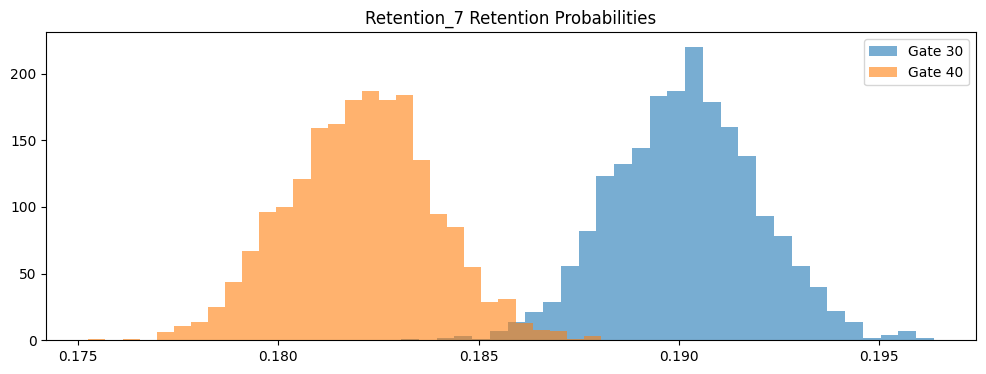

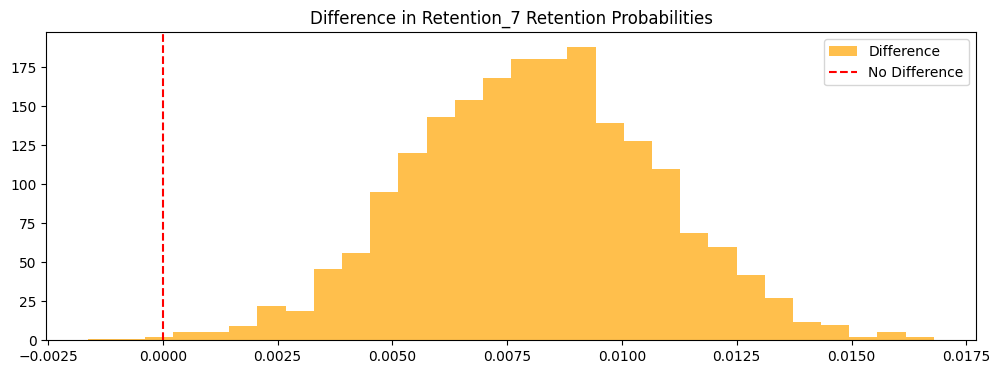


Retention_7 Retention Analysis Summary:
                         mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
p_30_retention_7        0.190  0.002     0.187      0.194        0.0      0.0   
p_40_retention_7        0.182  0.002     0.179      0.186        0.0      0.0   
difference_retention_7  0.008  0.003     0.004      0.014        0.0      0.0   

                        ess_bulk  ess_tail  r_hat  
p_30_retention_7          1870.0    1522.0    1.0  
p_40_retention_7          2061.0    1545.0    1.0  
difference_retention_7    1957.0    1327.0    1.0  
Probability Gate 30 > Gate 40: 99.85%


In [1]:
import pandas as pd
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

def load_data(file_path):
    """Loads and displays an overview of the dataset."""
    data = pd.read_csv(file_path)
    print("Dataset Overview:")
    print("-" * 50)
    print(f"Total Samples: {len(data)}")
    print(f"Versions Distribution:\n{data['version'].value_counts()}")
    retention_summary = data.groupby('version')[['retention_1', 'retention_7']].mean()
    print("\nRetention Rates:")
    print(retention_summary)
    return data

def perform_bayesian_analysis(data, retention_types):
    """Runs Bayesian analysis for given retention types."""
    traces = {}

    for retention_type in retention_types:
        gate_30_retention = data[data['version'] == 'gate_30'][retention_type]
        gate_40_retention = data[data['version'] == 'gate_40'][retention_type]

        with pm.Model() as model:
            p_30 = pm.Beta(f'p_30_{retention_type}', alpha=1, beta=1)
            p_40 = pm.Beta(f'p_40_{retention_type}', alpha=1, beta=1)

            obs_30 = pm.Bernoulli(f'obs_30_{retention_type}', p=p_30, observed=gate_30_retention)
            obs_40 = pm.Bernoulli(f'obs_40_{retention_type}', p=p_40, observed=gate_40_retention)

            difference = pm.Deterministic(f'difference_{retention_type}', p_30 - p_40)

            trace = pm.sample(1000, tune=1000, chains=2, random_seed=42)
            traces[retention_type] = trace

    return traces

def visualize_analysis(traces, retention_types):
    """Visualizes the posterior distributions and differences for retention analyses."""
    for retention_type in retention_types:
        trace = traces[retention_type]
        p_30_samples = trace.posterior[f'p_30_{retention_type}'].values.flatten()
        p_40_samples = trace.posterior[f'p_40_{retention_type}'].values.flatten()
        difference_samples = trace.posterior[f'difference_{retention_type}'].values.flatten()

        # Plot posterior distributions
        plt.figure(figsize=(12, 4))
        plt.hist(p_30_samples, bins=30, alpha=0.6, label='Gate 30')
        plt.hist(p_40_samples, bins=30, alpha=0.6, label='Gate 40')
        plt.title(f'{retention_type.capitalize()} Retention Probabilities')
        plt.legend()
        plt.show()

        # Plot difference distribution
        plt.figure(figsize=(12, 4))
        plt.hist(difference_samples, bins=30, alpha=0.7, label='Difference', color='orange')
        plt.axvline(0, color='red', linestyle='--', label='No Difference')
        plt.title(f'Difference in {retention_type.capitalize()} Retention Probabilities')
        plt.legend()
        plt.show()

        print(f"\n{retention_type.capitalize()} Retention Analysis Summary:")
        print(az.summary(trace, var_names=[f'p_30_{retention_type}', f'p_40_{retention_type}', f'difference_{retention_type}'], hdi_prob=0.95))

        prob_superior = np.mean(difference_samples > 0)
        print(f"Probability Gate 30 > Gate 40: {prob_superior:.2%}")

def main(file_path):
    data = load_data(file_path)
    retention_types = ['retention_1', 'retention_7']
    traces = perform_bayesian_analysis(data, retention_types)
    visualize_analysis(traces, retention_types)

if __name__ == "__main__":
    file_path = "https://raw.githubusercontent.com/dustywhite7/Econ8310/master/AssignmentData/cookie_cats.csv"
    main(file_path)
